### Load Population Model

#### Necessary Files

- model architecture
- model weights

For Interventions and Outcome embeddings, this is the only code that has to be changed.

Using Theano backend.


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 192)           0                                            
____________________________________________________________________________________________________
input_1 (InputLayer)             (None, 422)           0                                            
____________________________________________________________________________________________________
embedding_2 (Embedding)          (None, 192, 300)      3000000     input_2[0][0]                    
____________________________________________________________________________________________________
embedding_1 (Embedding)          (None, 422, 300)      9000000     input_1[0][0]                    
___________________________________________________________________________________________

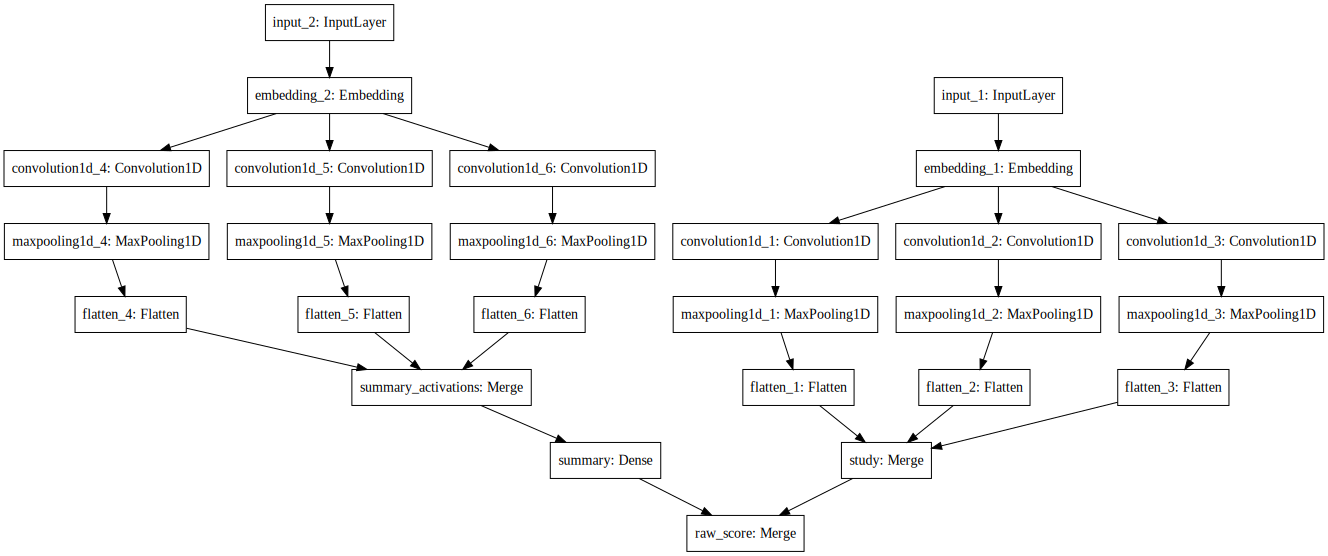

In [1]:
import keras
from keras.models import model_from_json

arch_path = 'store/weights/populations/architecture.json'
weight_path = 'store/weights/populations/weights.h5'

json_string = open(arch_path).read()
model = model_from_json(json_string)
model.load_weights(weight_path)
model.summary()

from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

Notice that this model takes in two pieces of text (an abstract and a summary), embeds them, and computes their similarity. Since we only care about embedding an abstract, we ignore the part of the model which embeds the summary.

### Vectorize Texts and Generate Embeddings

#### Necessary Files

- abstracts vectorizer
- `..preprocess/vectorizer.py` present and in your `$PYTHONPATH`
- some abstracts to work with (e.g. `cohen_tokenized.csv`)

In [2]:
import keras.backend as K

inputs = [model.inputs[0], K.learning_phase()]
outputs = model.get_layer('study').output
embed = K.function(inputs, outputs)

from IPython.display import display

vectorizer_path = '../preprocess/abstracts.p'
csv_path = '../preprocess/cohen_tokenized.csv'

vectorizer = pickle.load(open(vectorizer_path))
df = pd.read_csv(csv_path)
display(df.head())
X = vectorizer.texts_to_sequences(df.text)
TEST_MODE = 0
H = embed([X, TEST_MODE])

,pmid,drug,label,text
0,10023943,BetaBlockers,inc,"in patients with heart failure , beta-blockade..."
1,10024259,ProtonPumpInhibitors,inc,to assess intermittent treatment over qqq mont...
2,10029645,ACEInhibitors,inc,population-based studies have found that black...
3,10029786,CalciumChannelBlockers,pop,preterm labor is the leading cause of perinata...
4,10030097,BetaBlockers,inc,"prospective , randomized and long term multice..."


### Post-process Embeddings

- Replace any `NaN` values with `0` (if they exist - this probably isn't necessary anymore)
- Normalize to unit length

In [3]:
H[np.isnan(H)] = 0 # replace odd NaNs
norms = np.apply_along_axis(np.linalg.norm, axis=1, arr=H)
norms[norms == 0] = 1 # avoid division by zero norm
H /= norms[:, np.newaxis]

H.shape

(3770, 999)